In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import tensorflow as tf
import keras_core as keras
import keras_nlp
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend


**1. Loading the Datasets**

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


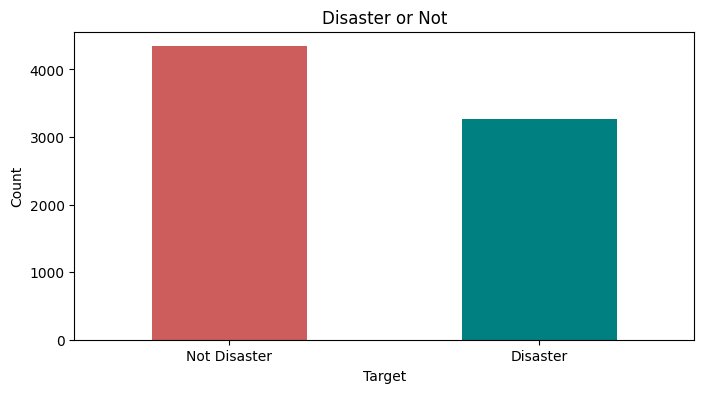

In [7]:
targets = train_df['target'].value_counts()

plt.figure(figsize=(8, 4))
targets.plot(kind='bar', color=['indianred', 'teal'])
plt.title('Disaster or Not')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)

plt.show()

In [8]:
train_df["length"] = np.vectorize(len)(train_df["text"])
test_df["length"] = np.vectorize(len)(test_df["text"])

In [9]:
print("Train Length Statistics")
print(train_df["length"].describe())
print()

Train Length Statistics
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64



In [10]:
print("Test Length Statistic")
print(test_df["length"].describe())
print()

Test Length Statistic
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64



In [11]:
from sklearn.model_selection import train_test_split

AUTO = tf.data.experimental.AUTOTUNE
X = train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_df["text"]

**Using BERT Model**

In [12]:
BATCH_SIZE = 32
EPOCHS = 5

In [13]:
preset = "bert_base_en_uncased"

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset=preset,
    sequence_length=160
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    preset=preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",          
    patience=2,                  
    restore_best_weights=True,   
    verbose=1                    
)

In [15]:
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=["accuracy"] 
)

history = classifier.fit(
    X_train, 
    y_train,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(X_val, y_val),  
    shuffle=True, 
    callbacks=[early_stopping], 
    verbose=1 
)


Epoch 1/5


I0000 00:00:1732721853.058516      97 service.cc:145] XLA service 0x7caa080027a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732721853.058563      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732721940.681979      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_105', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_69', 124 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 176 bytes spill stores, 176 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_xor_fusion_235', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732721940.781136      97 device_compiler.h:188] Compiled cluster using XLA!  This l

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7359 - loss: 0.5483

I0000 00:00:1732722101.663237      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 124 bytes spill stores, 124 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 290s 914ms/step - accuracy: 0.7365 - loss: 0.5477 - val_accuracy: 0.8385 - val_loss: 0.4034
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 90s 472ms/step - accuracy: 0.8457 - loss: 0.3732 - val_accuracy: 0.8457 - val_loss: 0.3872
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 90s 469ms/step - accuracy: 0.8815 - loss: 0.3100 - val_accuracy: 0.8418 - val_loss: 0.4077
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 90s 469ms/step - accuracy: 0.9125 - loss: 0.2479 - val_accuracy: 0.8326 - val_loss: 0.4581
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [16]:
y_train_pred = classifier.predict(X_train)

191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step


F1 score: 0.8710929519918283


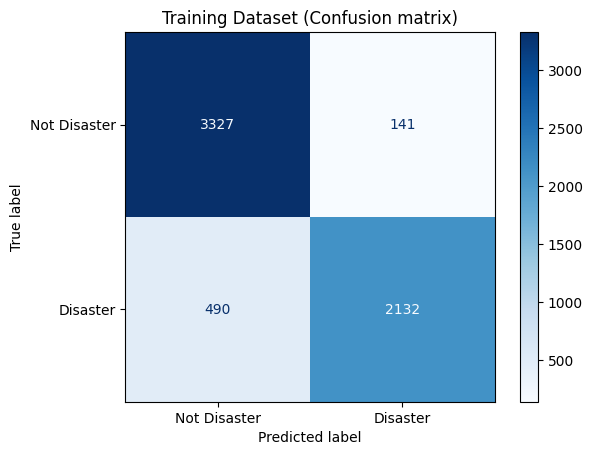

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

display = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_train_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Training Dataset (Confusion matrix)")

tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_train_pred, axis=1)).ravel()
f1_score = tp / (tp + (fp + fn) / 2)

print("F1 score:", f1_score)

In [19]:
y_val_pred = classifier.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step


F1 score: 0.8081632653061225


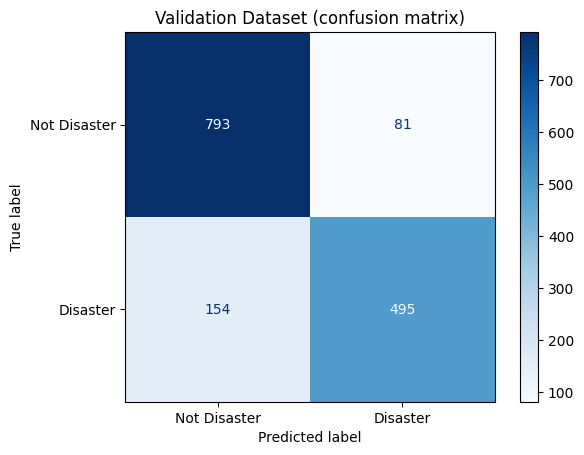

In [20]:
display = ConfusionMatrixDisplay.from_predictions(
    y_val,
    np.argmax(y_val_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Validation Dataset (confusion matrix)")

tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_val_pred, axis=1)).ravel()
f1_score = tp / (tp + (fp + fn) / 2)

print("F1 score:", f1_score)

In [21]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step
Your submission was successfully saved!
